# Visualising Segmentation

This notebook is a brief overview of loading the network from the bundle with the save weights and performing segmentation on a single 2D image. 

In [2]:
import matplotlib.pyplot as plt
import monai
import torch
import numpy as np
import SimpleITK as sitk
import scipy.interpolate as spi
from scipy.ndimage import zoom
import os

Example image from case SC-N-2 of the [Sunnybrook Cardiac Dataset](http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/).

Original shape: (10, 216, 256), Resampled shape: (10, 295, 350)
Original spacing: [ 1.36719  1.36719 10.     ], New spacing: (1.0, 1.0, 10.0)
(10, 295, 350)


NiftiImageIO (0x31fda3060): /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/training/patient014/patient014_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x31fda3060): /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/training/patient014/patient014_frame01.nii.gz has unexpected scales in sform



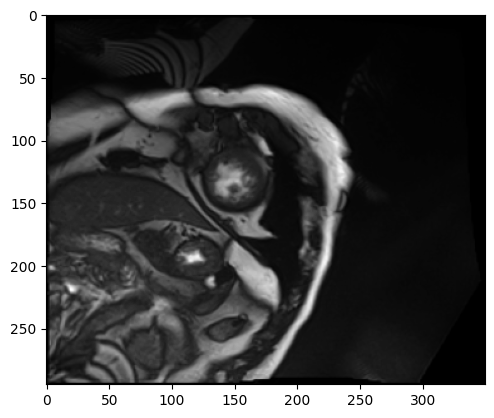

In [40]:
def monotonic_zoom_interpolate(image_np, resize_factor):
    """
    Apply monotonic zoom interpolation to a given image.
    """
    result = image_np.copy()
    
    for axis, factor in enumerate(resize_factor[::-1]):
        # Create a new array for the interpolated values
        new_length = int(result.shape[axis] * factor)
        x_old = np.arange(result.shape[axis])
        x_new = np.linspace(0, result.shape[axis] - 1, new_length)
        
        # Perform monotonic interpolation
        pchip_interp = spi.PchipInterpolator(x_old, result.take(indices=x_old, axis=axis), axis=axis)
        result = pchip_interp(x_new)

    return result

def process_single_slice_dicom(dicom_file, target_resolution):
    """
    Load and standardize the spacing of a single-slice DICOM file.
    """
    
    # Load the DICOM file
    image = sitk.ReadImage(dicom_file)
    current_spacing = np.array(image.GetSpacing())

    resize_factor = np.array([current_spacing[0] / target_resolution[0], 
                               current_spacing[1] / target_resolution[1], 
                               1.0])
    # resize_factor = np.array([1.0, 1.0, 1.0])   
    new_real_shape = np.array(image.GetSize()) * resize_factor

    new_shape = np.round(new_real_shape).astype(int)
    
    real_resize_factor = new_shape / np.array(image.GetSize())
    
    image_np = sitk.GetArrayFromImage(image)

    # image_resampled_np = zoom(image_np, real_resize_factor[::-1], order=0)
    image_resampled_np = monotonic_zoom_interpolate(image_np, real_resize_factor)

    image_resampled = sitk.GetImageFromArray(image_resampled_np)

    new_spacing = np.array([target_resolution[0], target_resolution[1], current_spacing[2]])

    image_resampled.SetSpacing(new_spacing)
    
    print(f"Original shape: {image_np.shape}, Resampled shape: {image_resampled_np.shape}")
    print(f"Original spacing: {current_spacing}, New spacing: {image_resampled.GetSpacing()}")

    return image_resampled, image_resampled_np

_ , image_resampled_np = process_single_slice_dicom("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/training/patient014/patient014_frame01.nii.gz", [1.0, 1.0])
print(image_resampled_np.shape)
#plot the image
plt.imshow(image_resampled_np[9], cmap='gray')
plt.show()

In [162]:
#padd
def process_Dimension_by_padding(numpy_image, target_resolution):
    """
    Load and standardize the resolution of a single-slice DICOM file using padding.
    """
    image = sitk.GetImageFromArray(numpy_image)
    # image = sitk.ReadImage(dicom_file)
    constant_val = int(sitk.GetArrayFromImage(image).min())

    current_size = np.array(image.GetSize())
    padding_left_right = target_resolution[0] - current_size[0]
    padding_top_bottom = target_resolution[1] - current_size[1]
    padding_left = int(padding_left_right // 2)
    padding_right = int(padding_left_right - padding_left)
    padding_top = int(padding_top_bottom // 2)
    padding_bottom = int(padding_top_bottom - padding_top)

    transformed = sitk.ConstantPad(image,(padding_left,padding_top,0),(padding_right,padding_bottom,0),constant_val)
    return transformed

target_resolution = (265, 256)
im = process_Dimension_by_padding(image_resampled_np, target_resolution)
im = sitk.GetArrayFromImage(im)
im = im[9]
print(im.shape)
# print(im[0].shape)
# im = im[0]
plt.imshow(im, cmap="gray")

TypeError: in method 'ConstantPad', argument 2 of type 'std::vector< unsigned int,std::allocator< unsigned int > >'

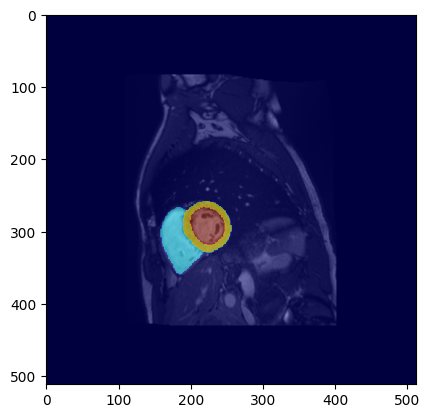

In [4]:
im = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/train_numpy/patient079/patient079_frame01_slice_1_ACDC.npy")
mask = im[1,:,:]
im = im[0,:,:]
# load nii image
# im = sitk.ReadImage("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/training/patient014/patient014_frame01.nii.gz")
# im = sitk.GetArrayFromImage(im)
#read dicom image
# im = sitk.ReadImage("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/SunnyBrook/SCD_IMAGES_01/SCD0000101/CINESAX_300/IM-0003-0045.dcm")
# im = sitk.GetArrayFromImage(im)

# print(im.shape)
# print(im[0].shape)
# im = im[9]
plt.imshow(im, cmap="gray")
plt.imshow(mask, cmap="jet", alpha=0.5)

In [3]:
import numpy as np

def remove_outliers_zscore(mask, target_value, threshold=0.5):
    # X distribution (columns)
    x_distribution = np.sum(mask == target_value, axis=0)  # Sum target values along rows
    x_mean = np.mean(x_distribution)
    x_std = np.std(x_distribution)
    x_zscores = (x_distribution - x_mean) / x_std
    x_outliers = (x_zscores < threshold)  # Identify outlier columns
    #plot x_distribution and the outliers
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.bar(range(mask.shape[1]), x_distribution, color='blue', alpha=0.7)
    # plt.title(f"Distribution of {target_value} (X-axis)")
    # plt.xlabel("X Pixels (Columns)")
    # plt.ylabel(f"Count of {target_value}")
    # plt.grid(True)
    # plt.subplot(1, 2, 2)
    # plt.bar(range(mask.shape[1]), x_outliers, color='red', alpha=0.7)
    # plt.title(f"Outliers of {target_value} (X-axis)")
    # plt.xlabel("X Pixels (Columns)")
    # plt.ylabel(f"Outliers of {target_value}")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    mask[:, x_outliers] = np.where(mask[:, x_outliers] == target_value, 0, mask[:, x_outliers])

    # Y distribution (rows)
    y_distribution = np.sum(mask == target_value, axis=1)  # Sum target values along columns
    y_mean = np.mean(y_distribution)
    y_std = np.std(y_distribution)
    y_zscores = (y_distribution - y_mean) / x_std
    y_outliers = (y_zscores < threshold)  # Identify outlier rows
    mask[y_outliers, :] = np.where(mask[y_outliers, :] == target_value, 0, mask[y_outliers, :])

    return mask


In [9]:
def predict_the_seg(im):
    # print("Predicting the segmentation")
    # print(f"Input image shape: {image.shape}")
    parser = monai.bundle.load_bundle_config("..", "train.json")
    net = parser.get_parsed_content("network_def")  # "network" loads the network into GPU which we'll avoid for simplicity here
    # net.load_state_dict(torch.load("../models/model.pt"))
    net.load_state_dict(torch.load("../models/model.pt", map_location=torch.device('cpu')))
    inputd = torch.from_numpy(im / im.max()).float()
    # inputd = torch.from_numpy(im).float()
    pred = net(inputd[None, None, :, :])  # adding batch and channel dimensions to inputd
    pred = torch.softmax(pred[0], dim=0)  # activation and remove batch dimension
    seg = torch.argmax(pred, dim=0).data.numpy()  # convert to segmentation
    return seg
def process_segmented(seg):
    seg[seg == 3] = 0   # remove the mask of value 3
    seg = remove_outliers_zscore(seg, 1)
    seg = remove_outliers_zscore(seg, 2) 
    return seg
    
def process_mask(mask):
    mask[mask == 1] = 0
    mask[mask == 3] = 1
    return mask

def dice_factor(mask, seg, target_value):
    mask = mask == target_value
    seg = seg == target_value
    intersection = np.sum(mask & seg)
    union = np.sum(mask | seg)
    return 2 * intersection / (intersection + union)

def calculate_avg_dice(mask, seg):
    dice_1 = dice_factor(mask, seg, 1)
    # print(dice_1)
    dice_2 = dice_factor(mask, seg, 2)
    # print(dice_2)
    return (dice_1 + dice_2) / 2

#trial example
# seg = predict_the_seg(im)
# seg = process_segmented(seg)
# mask = process_mask(mask)
# print(calculate_avg_dice(mask, seg))

In [10]:
dataset_path = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/train_numpy"
#loop on the dataset
count = 0
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".npy"):
            im = np.load(os.path.join(root, file))
            mask = im[1,:,:]
            im = im[0,:,:]
            seg = predict_the_seg(im)
            seg = process_segmented(seg)
            mask = process_mask(mask)
            avg_score = calculate_avg_dice(mask, seg)
            if avg_score < 0.6:
                count += 1
                print(f"the file {file} has an average dice score of {avg_score}")

print(f"the number of files with an average dice score less than 0.6 is {count}")
            

/var/folders/v2/vml429gj3w93xjbkkns2f7d80000gn/T/ipykernel_17287/4204996825.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("../models/mod

the file patient015_frame10_slice_8_ACDC.npy has an average dice score of 0.16884661117717004
the file patient015_frame01_slice_3_ACDC.npy has an average dice score of 0.14571609536183844
the file patient015_frame10_slice_4_ACDC.npy has an average dice score of 0.5061678301010146
the file patient015_frame01_slice_1_ACDC.npy has an average dice score of 0.4191354443721542


KeyboardInterrupt: 

/var/folders/v2/vml429gj3w93xjbkkns2f7d80000gn/T/ipykernel_39242/3708053064.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("../models/mod

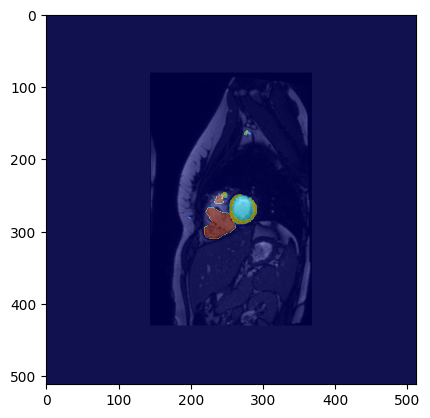

In [25]:
image_slice = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/train_numpy/patient085/patient085_frame01_slice_10_ACDC.npy"
im = np.load(image_slice)
mask = im[1,:,:]
im = im[0,:,:]
seg = predict_the_seg(im)
# seg = process_segmented(seg)
plt.imshow(im, cmap="gray")
plt.imshow(seg, cmap="jet", alpha=0.5)
plt.show()

In [ ]:
# function that calculate the center of mass of the mask
from scipy.ndimage import center_of_mass

def median_center_of_mass_of_time_series(time_series):
    """
    Calculate the center of mass of the mask.
    """
    center_of_masses = {}
    centers = []
    for root, dirs, files in os.walk(time_series):
        print(root)

        for file in files:
            if file.endswith(".npy"):
                im = np.load(os.path.join(root, file))

                mask = im[1,:,:]
                im = im[0,:,:]
                
                seg = predict_the_seg(im)
                seg = process_segmented(seg)
                # plt.imshow(im, cmap="gray")
                # plt.imshow(seg, cmap="jet", alpha=0.5)
                # plt.show()
                center = center_of_mass(seg)
                center_of_masses[file] = center
                centers.append(center)

    median_center = np.median(centers, axis=0)
    return median_center, center_of_masses

time_series = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/train_numpy/patient085"
median , center_masses = median_center_of_mass_of_time_series(time_series)
eclidean_distance = []
for centers in center_masses:
    eclidean_distance.append(np.linalg.norm(centers - median))

#plot median center of mass on any image
im = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/train_numpy/patient085/patient085_frame01_slice_2_ACDC.npy")
mask = im[1,:,:]
im = im[0,:,:]
plt.imshow(im, cmap="gray")
plt.scatter(median[1], median[0], c='red')
plt.show()


/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Data/ACDC/database/train_numpy/patient085


/var/folders/v2/vml429gj3w93xjbkkns2f7d80000gn/T/ipykernel_39242/3708053064.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("../models/mod

AxisError: axis 0 is out of bounds for array of dimension 0

In [80]:
# count how many slices do we have in total
count = 0
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".npy"):
            count += 1
print(f"the total number of slices is {count}")

the total number of slices is 1902


In [5]:
# check max and min values
print("max: ", np.max(im))
print("min: ", np.min(im))

max:  4.813148494079049
min:  -1.0128620650960596


The bundle parser is then created to load data from the metadata file and train configuration:

In [6]:
parser = monai.bundle.load_bundle_config("..", "train.json")

/opt/homebrew/lib/python3.12/site-packages/monai/bundle/reference_resolver.py:216: UserWarning: Detected deprecated name 'optional_packages_version' in configuration file, replacing with 'required_packages_version'.
  warnings.warn(


A network is created from the configured definition and then initialised with the stored weights:

In [7]:
net = parser.get_parsed_content("network_def")  # "network" loads the network into GPU which we'll avoid for simplicity here
# net.load_state_dict(torch.load("../models/model.pt"))
net.load_state_dict(torch.load("../models/model.pt", map_location=torch.device('cpu')))

/var/folders/v2/vml429gj3w93xjbkkns2f7d80000gn/T/ipykernel_61832/2275696717.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("../models/mod

<All keys matched successfully>

The input data is in it's raw state with an arbitrary value range. From the transforms used in training it's clear that the data must be normalised to the \[0,1\] range and be in float32 format. This can be done just by dividing the image by it's largest value because it's known the lowest value is 0. The batch and channels dimensions are added befor being passed to the network:

In [8]:
inputd = torch.from_numpy(im / im.max()).float()
# inputd = torch.from_numpy(im).float()
pred = net(inputd[None, None, :, :])  # adding batch and channel dimensions to inputd

The resulting prediction needs to be activated with softmax and then converting into a segmentation by applying argmax in the channel dimension:

In [9]:
pred = torch.softmax(pred[0], dim=0)  # activation and remove batch dimension
seg = torch.argmax(pred, dim=0).data.numpy()  # convert to segmentation


Finally the segmentation can be overlaid with the original image:

In [10]:
# print segmentation values
print("max: ", np.max(seg))
print("min: ", np.min(seg))
print("unique: ", np.unique(seg))
print(seg == 2)

max:  3
min:  0
unique:  [0 1 2 3]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


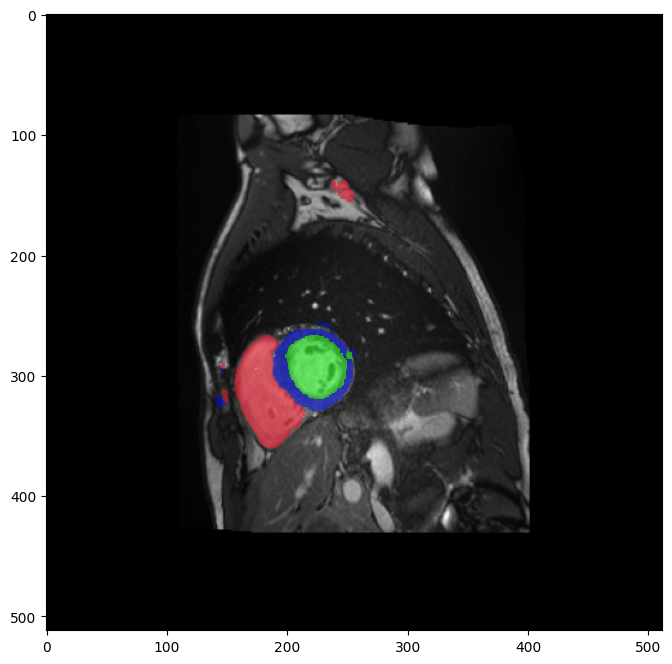

In [11]:
plt.figure(figsize=(8, 8))
plt.imshow(im, cmap="gray")
plt.imshow(seg , alpha=(seg != 0) * 0.5, cmap="hsv", interpolation="none")
# plt.imshow(seg == 3, alpha= 0.5)



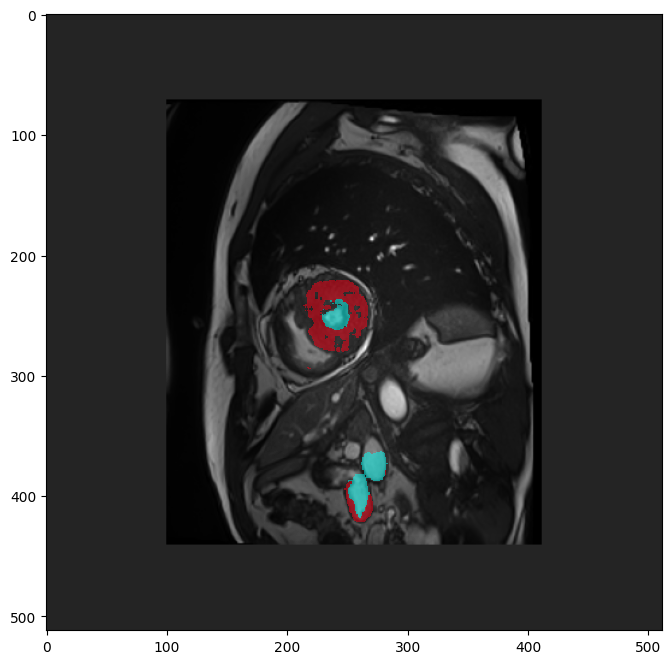

In [70]:
# remove the mask of value 3
seg[seg == 3] = 0   # remove the mask of value 3
plt.figure(figsize=(8, 8))
plt.imshow(im, cmap="gray")
plt.imshow(seg, alpha=(seg != 0) * 0.5, cmap="hsv", interpolation="none")


In [116]:
# print(seg)
# print mask values
print("max: ", np.max(seg))
print("min: ", np.min(seg))

max:  2
min:  0


x_distribution:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

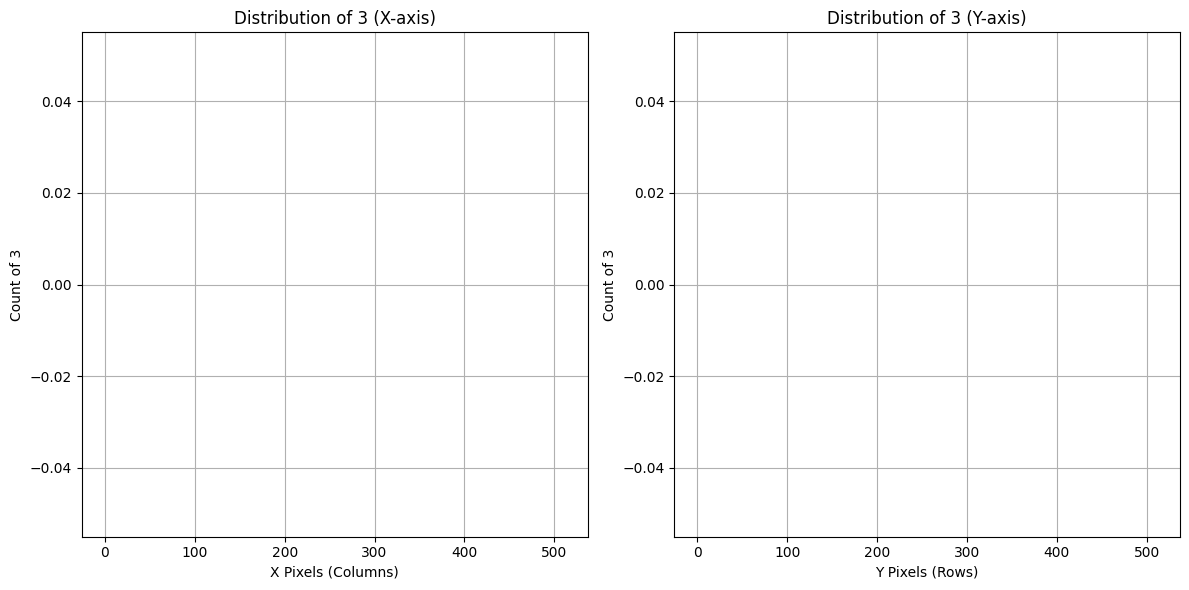

In [117]:
target_value = 3

# Count occurrences of the target value along each axis
x_distribution = np.sum(seg == target_value, axis=0)  # Sum along rows (for each column)
y_distribution = np.sum(seg == target_value, axis=1)  # Sum along columns (for each row)
print("x_distribution: ", x_distribution)
# Plot the distributions
plt.figure(figsize=(12, 6))

# X-axis distribution
plt.subplot(1, 2, 1)
plt.bar(range(seg.shape[1]), x_distribution, color='blue', alpha=0.7)
plt.title(f"Distribution of {target_value} (X-axis)")
plt.xlabel("X Pixels (Columns)")
plt.ylabel(f"Count of {target_value}")
plt.grid(True)

# Y-axis distribution
plt.subplot(1, 2, 2)
plt.bar(range(seg.shape[0]), y_distribution, color='green', alpha=0.7)
plt.title(f"Distribution of {target_value} (Y-axis)")
plt.xlabel("Y Pixels (Rows)")
plt.ylabel(f"Count of {target_value}")
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [71]:
import numpy as np

def remove_outliers_zscore(mask, target_value, threshold=0.5):
    # X distribution (columns)
    x_distribution = np.sum(mask == target_value, axis=0)  # Sum target values along rows
    x_mean = np.mean(x_distribution)
    x_std = np.std(x_distribution)
    x_zscores = (x_distribution - x_mean) / x_std
    x_outliers = (x_zscores < threshold)  # Identify outlier columns
    #plot x_distribution and the outliers
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(mask.shape[1]), x_distribution, color='blue', alpha=0.7)
    plt.title(f"Distribution of {target_value} (X-axis)")
    plt.xlabel("X Pixels (Columns)")
    plt.ylabel(f"Count of {target_value}")
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.bar(range(mask.shape[1]), x_outliers, color='red', alpha=0.7)
    plt.title(f"Outliers of {target_value} (X-axis)")
    plt.xlabel("X Pixels (Columns)")
    plt.ylabel(f"Outliers of {target_value}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    mask[:, x_outliers] = np.where(mask[:, x_outliers] == target_value, 0, mask[:, x_outliers])

    # Y distribution (rows)
    y_distribution = np.sum(mask == target_value, axis=1)  # Sum target values along columns
    y_mean = np.mean(y_distribution)
    y_std = np.std(y_distribution)
    y_zscores = (y_distribution - y_mean) / x_std
    y_outliers = (y_zscores < threshold)  # Identify outlier rows
    mask[y_outliers, :] = np.where(mask[y_outliers, :] == target_value, 0, mask[y_outliers, :])
    # plot y_distribution and the outliers
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(mask.shape[0]), y_distribution, color='green', alpha=0.7)
    plt.title(f"Distribution of {target_value} (Y-axis)")
    plt.xlabel("Y Pixels (Rows)")
    plt.ylabel(f"Count of {target_value}")
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.bar(range(mask.shape[0]), y_outliers, color='red', alpha=0.7)
    plt.title(f"Outliers of {target_value} (Y-axis)")
    plt.xlabel("Y Pixels (Rows)")
    plt.ylabel(f"Outliers of {target_value}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

    return mask


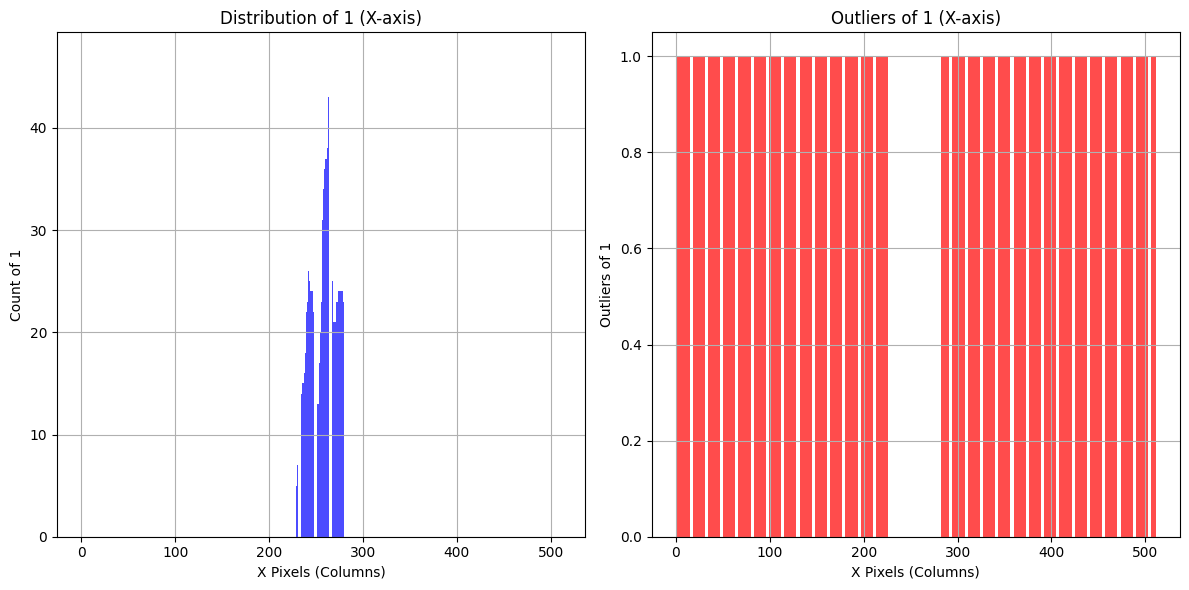

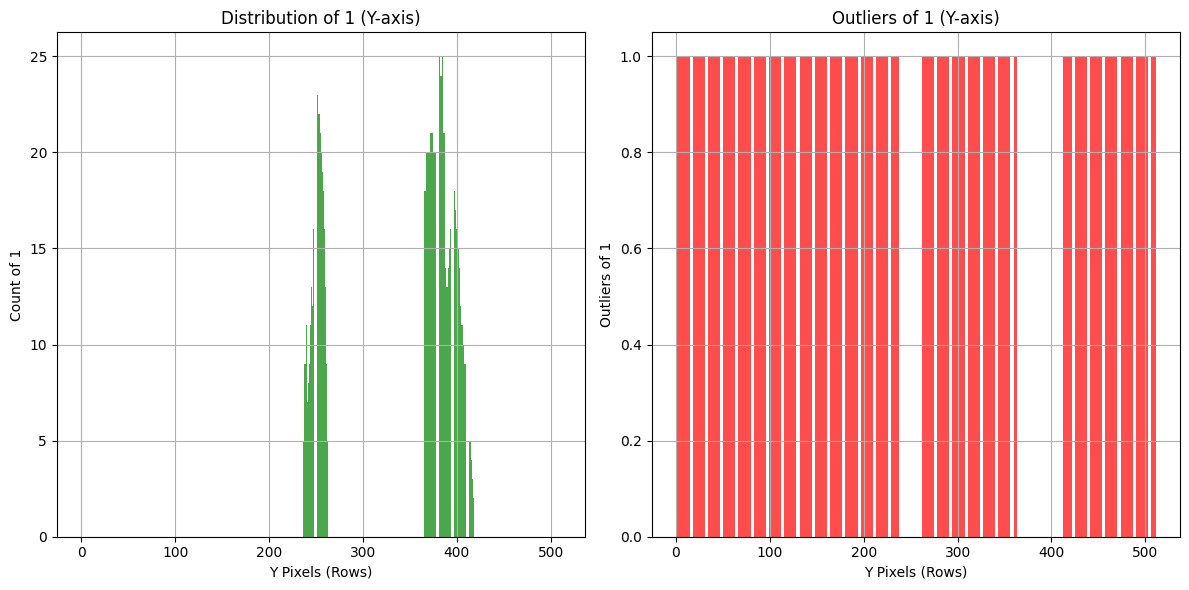

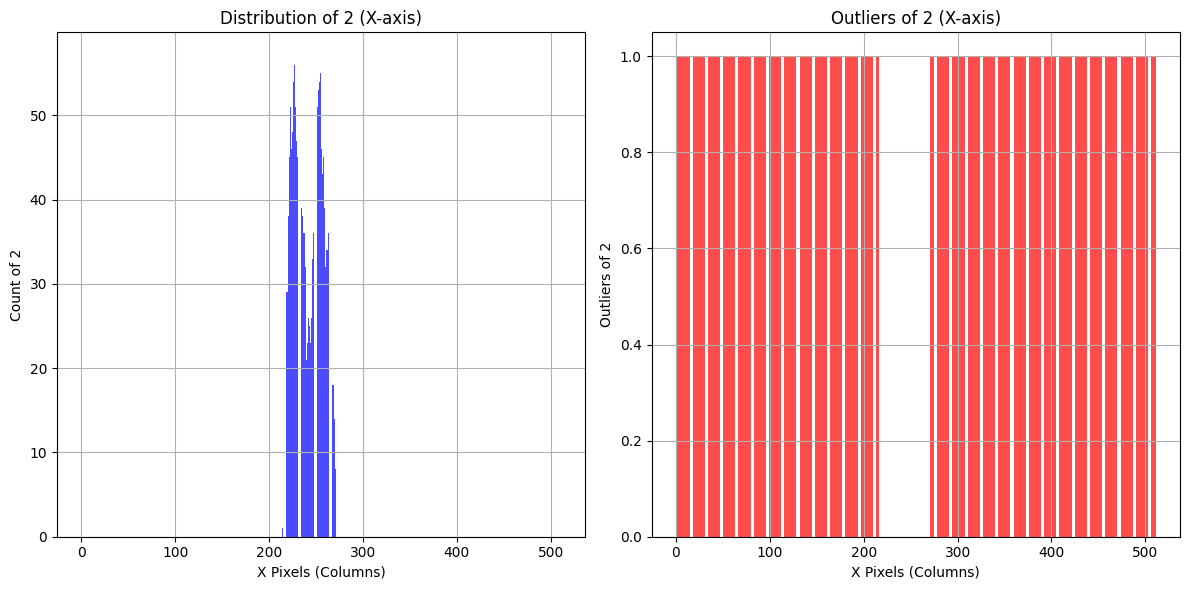

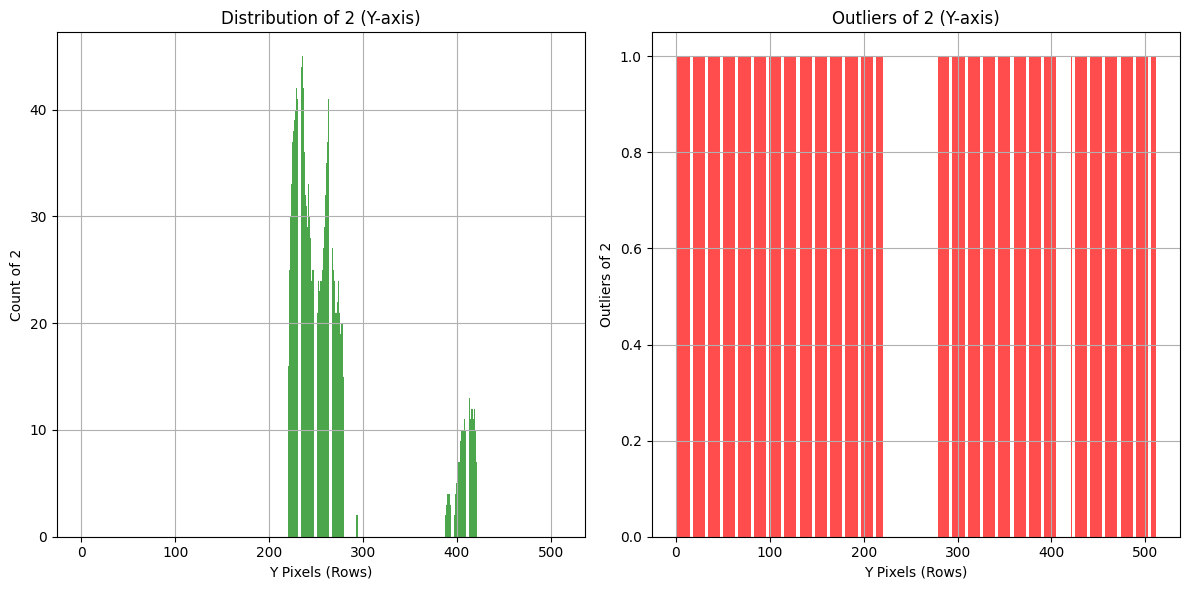

In [72]:
#remove outliers
seg = remove_outliers_zscore(seg, 1)
seg = remove_outliers_zscore(seg, 2)    


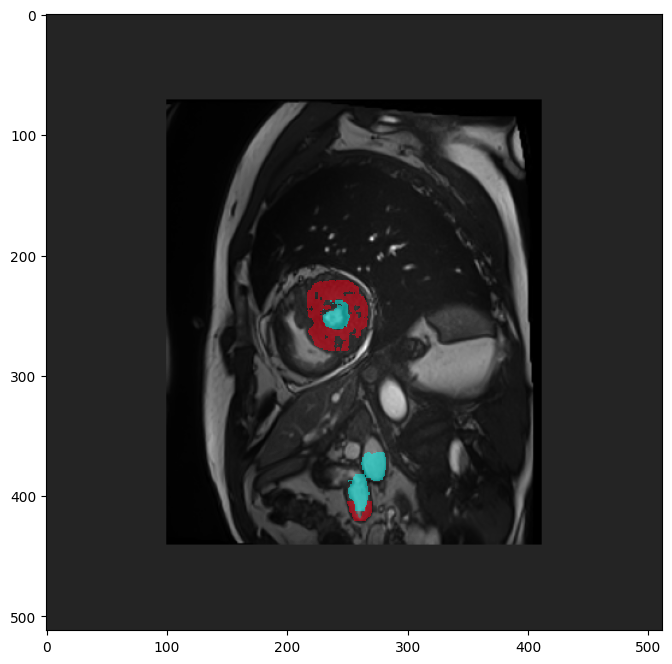

In [59]:
plt.figure(figsize=(8, 8))
plt.imshow(im, cmap="gray")
plt.imshow(seg, alpha=(seg != 0) * 0.5, cmap="hsv", interpolation="none")
#plot only outer myocardium
# plt.imshow(seg == 1)

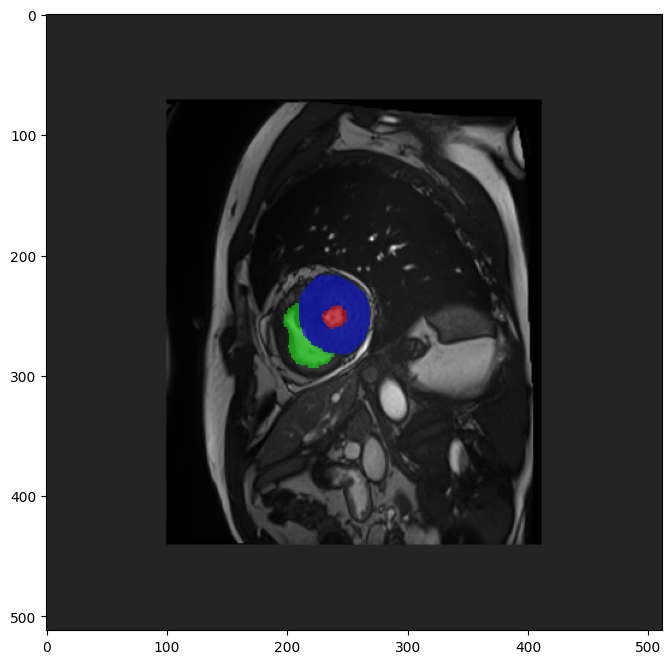

In [60]:
#show the real mask of the image
plt.figure(figsize=(8, 8))
# mask[mask == 1] = 0
plt.imshow(im, cmap="gray")
plt.imshow(mask, alpha=(mask != 0) * 0.5, cmap="hsv", interpolation="none")
# mask[mask == 3] = 1
# mask[mask != 0] = 1
# plt.imshow(mask == 1)
# print(mask == 1)/

In [122]:
# print dice factor between mask and seg
def dice_factor(mask, seg, target_value):
    mask = mask == target_value
    seg = seg == target_value
    intersection = np.sum(mask & seg)
    union = np.sum(mask | seg)
    return 2 * intersection / (intersection + union)

print("Dice factor for mask 1: ", dice_factor(mask, seg, 2))

Dice factor for mask 1:  0.8898514851485149


Center of mass: (281.7685624012638, 246.05963665086887)


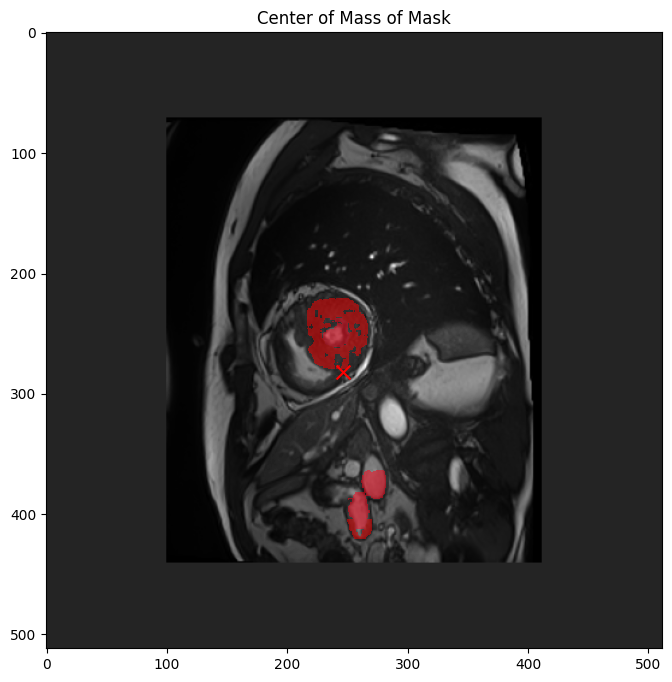

In [61]:
# plot the center of mass of mask
from scipy.ndimage import center_of_mass

# Calculate the center of mass of the mask
center = center_of_mass(seg)
print("Center of mass:", center)

# Plot the
plt.figure(figsize=(8, 8))
plt.imshow(im, cmap="gray")
plt.imshow(seg == 1, alpha=(seg != 0) * 0.5, cmap="hsv", interpolation="none")
plt.scatter(center[1], center[0], c='red', s=100, marker='x')
plt.title("Center of Mass of Mask")
plt.show()



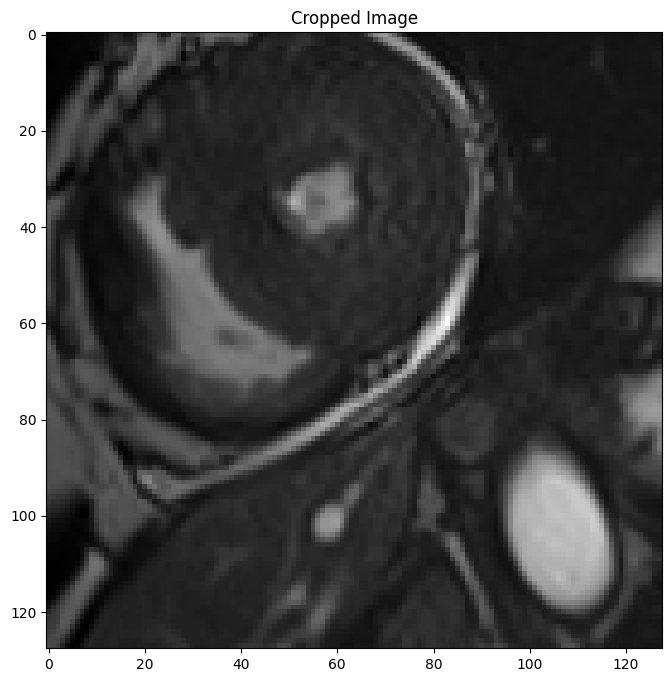

In [62]:
# crop a window of size 128x128 around the center of mass
def crop_center(image, cropx, cropy):
    y, x = center
    startx = int(x - cropx // 2)
    starty = int(y - cropy // 2)
    return image[starty:starty + cropy, startx:startx + cropx]

# Crop a window of size 128x128 around the center of mass
crop_size = 128
cropped_image = crop_center(im, crop_size, crop_size)   # crop the image
#plot the cropped image 
plt.figure(figsize=(8, 8))
plt.imshow(cropped_image, cmap="gray")
plt.title("Cropped Image")
plt.show()